In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!python --version

Python 3.11.13


In [19]:
import torch
torch.__version__

'2.6.0+cu124'

In [20]:
import sys
sys.path.append('/content/drive/MyDrive/Vit/Classification/')

In [21]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['benign','malignant']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [24]:
!pip install torchinfo

In [25]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [26]:
# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/Vit/Data/melanoma_cancer_dataset_small/test'
test_dir = '/content/drive/MyDrive/Vit/Data/melanoma_cancer_dataset_small/train'

In [27]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [28]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
#datasets: allows loading image datasets from folders.
#transforms: used to define preprocessing (resize, normalize, etc.)
#DataLoader: handles batching, shuffling, and parallel loading.

NUM_WORKERS = os.cpu_count() #Returns the number of CPU cores available on your machine

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names (folder names)
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True, # Normally, when loading data on the CPU and transferring it to the GPU, the data must be copied from regular RAM to GPU memory.
                     #Using pinned memory makes this transfer faster,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [29]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [30]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=3e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train (model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3766 | train_acc: 0.8293 | test_loss: 0.5318 | test_acc: 0.7363
Epoch: 2 | train_loss: 0.2643 | train_acc: 0.8822 | test_loss: 0.4980 | test_acc: 0.7558
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9111 | test_loss: 0.3886 | test_acc: 0.8112
Epoch: 4 | train_loss: 0.1882 | train_acc: 0.9327 | test_loss: 0.7789 | test_acc: 0.6685
Epoch: 5 | train_loss: 0.2023 | train_acc: 0.9159 | test_loss: 0.5416 | test_acc: 0.7422
Epoch: 6 | train_loss: 0.1480 | train_acc: 0.9519 | test_loss: 0.5053 | test_acc: 0.7568
Epoch: 7 | train_loss: 0.1421 | train_acc: 0.9495 | test_loss: 0.4330 | test_acc: 0.7954
Epoch: 8 | train_loss: 0.1348 | train_acc: 0.9519 | test_loss: 0.4830 | test_acc: 0.7712
Epoch: 9 | train_loss: 0.1124 | train_acc: 0.9663 | test_loss: 0.4939 | test_acc: 0.7668
Epoch: 10 | train_loss: 0.1019 | train_acc: 0.9663 | test_loss: 0.6140 | test_acc: 0.7350


In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

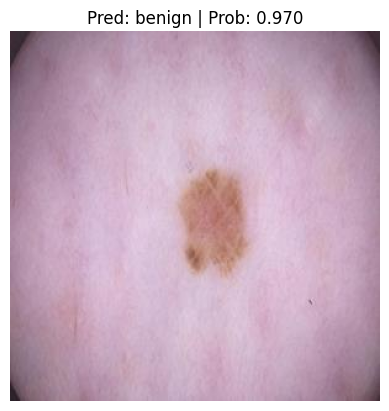

In [40]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
img1 = "/content/drive/MyDrive/Vit/Data/melanoma_cancer_dataset/test/benign/melanoma_10000.jpg"
img2 = "/content/drive/MyDrive/Vit/Data/melanoma_cancer_dataset/test/malignant/melanoma_10105.jpg"
img3 = "/content/drive/MyDrive/Vit/Data/melanoma_cancer_dataset/test/malignant/melanoma_10117.jpg"
img4 = '/content/drive/MyDrive/Vit/Data/melanoma_cancer_dataset/test/benign/melanoma_10009.jpg'
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=img1,
                    class_names=class_names)

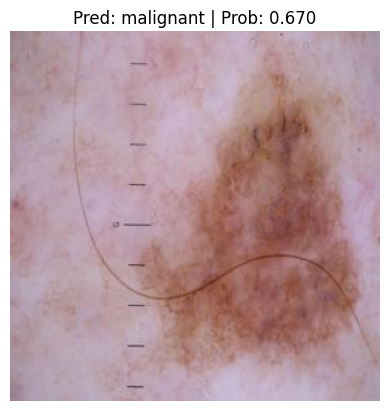

In [35]:
pred_and_plot_image(model=pretrained_vit,
                    image_path=img2,
                    class_names=class_names)

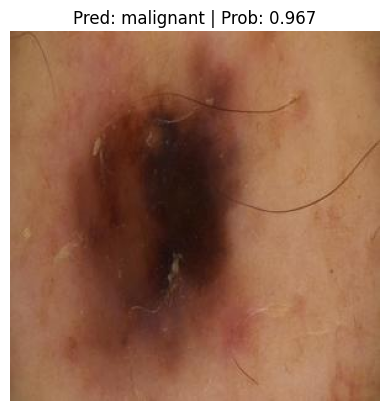

In [41]:
pred_and_plot_image(model=pretrained_vit,
                    image_path=img3,
                    class_names=class_names)

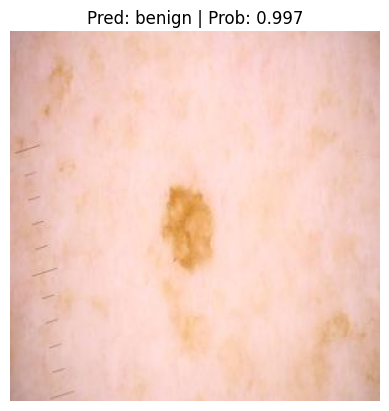

In [39]:
pred_and_plot_image(model=pretrained_vit,
                    image_path=img4,
                    class_names=class_names)